<a href="https://colab.research.google.com/github/nathanddaniel/Baseball-Pitchers-ERA-Model/blob/main/mlb_pitching_era_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# installing dependencies

!pip install opendatasets
!pip install pandas

In [57]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/johnadamek/game-by-game-individual-pitching-data-20172020")

Skipping, found downloaded files in "./game-by-game-individual-pitching-data-20172020" (use force=True to force download)


In [58]:
import pandas as pd
import numpy as np

# Load all years with low_memory=False to avoid dtype warnings
print("Loading data...")
df_2017 = pd.read_csv('/content/game-by-game-individual-pitching-data-20172020/pitching_2017.csv', low_memory=False)
df_2018 = pd.read_csv('/content/game-by-game-individual-pitching-data-20172020/pitching_2018.csv', low_memory=False)
df_2019 = pd.read_csv('/content/game-by-game-individual-pitching-data-20172020/pitching_2019.csv', low_memory=False)
df_2020 = pd.read_csv('/content/game-by-game-individual-pitching-data-20172020/pitching_2020.csv', low_memory=False)

def create_clean_season_data(df, year):
    """
    Transform game-by-game data into clean season statistics per pitcher
    """
    # Aggregate stats per pitcher
    season_stats = df.groupby('Player').agg({
        # Core pitching stats (sum across all games)
        'IP': 'sum',
        'H': 'sum',
        'R': 'sum',
        'ER': 'sum',
        'BB': 'sum',
        'SO': 'sum',
        'HR': 'sum',
        'HBP': 'sum',
        'BF': 'sum',  # Batters Faced

        # Game counts
        'Starter': 'sum',  # This becomes Games Started

        # Keep team info (first occurrence)
        'Team': 'first'
    }).reset_index()

    # Rename for clarity
    season_stats.rename(columns={'Starter': 'GS'}, inplace=True)

    # Add total games appeared
    season_stats['G'] = df.groupby('Player').size().values

    # Calculate ERA (Earned Run Average)
    season_stats['ERA'] = np.where(
        season_stats['IP'] > 0,
        (season_stats['ER'] / season_stats['IP']) * 9,
        np.nan
    )

    # Calculate advanced metrics
    season_stats['K_per_9'] = (season_stats['SO'] / season_stats['IP']) * 9
    season_stats['BB_per_9'] = (season_stats['BB'] / season_stats['IP']) * 9
    season_stats['HR_per_9'] = (season_stats['HR'] / season_stats['IP']) * 9
    season_stats['H_per_9'] = (season_stats['H'] / season_stats['IP']) * 9

    # WHIP (Walks plus Hits per Inning Pitched)
    season_stats['WHIP'] = (season_stats['H'] + season_stats['BB']) / season_stats['IP']

    # K/BB Ratio
    season_stats['K_BB_ratio'] = np.where(
        season_stats['BB'] > 0,
        season_stats['SO'] / season_stats['BB'],
        season_stats['SO']
    )

    # FIP (Fielding Independent Pitching) - often better predictor than ERA
    season_stats['FIP'] = (((13 * season_stats['HR']) +
                            (3 * season_stats['BB']) -
                            (2 * season_stats['SO'])) / season_stats['IP']) + 3.2

    # Innings per game (workload indicator)
    season_stats['IP_per_G'] = season_stats['IP'] / season_stats['G']

    # Add year
    season_stats['Year'] = year

    return season_stats

# Create clean data for each year
print("Creating clean season data...")
clean_2017 = create_clean_season_data(df_2017, 2017)
clean_2018 = create_clean_season_data(df_2018, 2018)
clean_2019 = create_clean_season_data(df_2019, 2019)
clean_2020 = create_clean_season_data(df_2020, 2020)

print(f"\n2017: {len(clean_2017)} pitchers")
print(f"2018: {len(clean_2018)} pitchers")
print(f"2019: {len(clean_2019)} pitchers")
print(f"2020: {len(clean_2020)} pitchers")

# Combine all years into one dataset
pitching_data = pd.concat([clean_2017, clean_2018, clean_2019, clean_2020], ignore_index=True)

print(f"\nTotal pitcher-seasons: {len(pitching_data)}")
print("\nFirst few rows:")
print(pitching_data.head(10))

Loading data...
Creating clean season data...

2017: 754 pitchers
2018: 799 pitchers
2019: 825 pitchers
2020: 731 pitchers

Total pitcher-seasons: 3109

First few rows:
          Player     IP  H   R  ER  BB   SO  HR  HBP   BF  ...        ERA  \
0      A.J. Cole   50.6  0  23  22  27   44   8  3.0  229  ...   3.913043   
1   A.J. Griffin   75.7  0  52  51  28   61  20  6.0  338  ...   6.063408   
2    A.J. Minter   12.9  5   5   5   2   26   1  0.0   60  ...   3.488372   
3   A.J. Schugel   28.5  4   8   7  14   27   3  0.0  136  ...   2.210526   
4       AJ Ramos   55.4  1  27  26  34   72   7  2.0  258  ...   4.223827   
5    Aaron Blair    3.0  0   5   5   5    3   1  0.0   19  ...  15.000000   
6   Aaron Bummer   17.8  7  11  11  15   17   4  1.0   91  ...   5.561798   
7     Aaron Loup   47.4  6  27  24  29   64   4  6.0  265  ...   4.556962   
8     Aaron Nola  167.3  0  67  66  49  184  18  2.0  693  ...   3.550508   
9  Aaron Sanchez   35.3  0  24  17  20   24   6  1.0  167  ..

In [59]:
# Filter for minimum innings pitched
# 50 IP is standard for relievers, but 2020 was a shortened season
def filter_qualified(df):
    """Remove pitchers with insufficient data"""
    if df['Year'].iloc[0] == 2020:
        # 2020 was a 60-game season (normal is 162)
        min_ip = 20
    else:
        min_ip = 50

    return df[df['IP'] >= min_ip].copy()

# Apply filter by year
pitching_qualified = pitching_data.groupby('Year').apply(filter_qualified).reset_index(drop=True)

print(f"Pitcher-seasons before filtering: {len(pitching_data)}")
print(f"Pitcher-seasons after filtering: {len(pitching_qualified)}")
print(f"\nBreakdown by year:")
print(pitching_qualified.groupby('Year').size())

Pitcher-seasons before filtering: 3109
Pitcher-seasons after filtering: 1201

Breakdown by year:
Year
2017    312
2018    296
2019    292
2020    301
dtype: int64


/tmp/ipython-input-1671955310.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pitching_qualified = pitching_data.groupby('Year').apply(filter_qualified).reset_index(drop=True)


In [60]:
# Select the most important columns for your analysis
final_columns = [
    'Player', 'Year', 'Team',
    'G', 'GS', 'IP',  # Games and innings
    'ERA', 'FIP', 'WHIP',  # Main performance metrics
    'SO', 'BB', 'HR', 'H',  # Core stats
    'K_per_9', 'BB_per_9', 'HR_per_9', 'H_per_9',  # Rate stats
    'K_BB_ratio', 'IP_per_G'  # Derived metrics
]

pitching_clean = pitching_qualified[final_columns].copy()

# Sort by Year and ERA
pitching_clean = pitching_clean.sort_values(['Year', 'ERA']).reset_index(drop=True)

print("\nFinal clean dataset:")
print(pitching_clean.head(15))
print(f"\nShape: {pitching_clean.shape}")
print(f"\nColumns: {pitching_clean.columns.tolist()}")

# Check for missing values
print("\nMissing values:")
print(pitching_clean.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(pitching_clean.describe())


Final clean dataset:
             Player  Year                   Team   G  GS     IP       ERA  \
0     Kenley Jansen  2017    Los Angeles Dodgers  65   0   63.9  1.408451   
1     Craig Kimbrel  2017         Boston Red Sox  67   0   66.2  1.495468   
2     Andrew Miller  2017      Cleveland Indians  57   0   52.4  1.717557   
3     Felipe Rivero  2017     Pittsburgh Pirates  73   0   68.8  1.831395   
4        Pat Neshek  2017  Philadelphia Phillies  71   0   53.0  1.867925   
5      Corey Knebel  2017      Milwaukee Brewers  76   0   71.8  1.880223   
6       Matt Albers  2017   Washington Nationals  63   0   51.2  1.933594   
7    Archie Bradley  2017   Arizona Diamondbacks  63   0   64.6  1.950464   
8   David Robertson  2017      Chicago White Sox  61   0   64.6  1.950464   
9       Ryan Madson  2017      Oakland Athletics  60   0   53.4  2.022472   
10       Chad Green  2017       New York Yankees  40   1   61.3  2.055465   
11     Cory Gearrin  2017   San Francisco Giants  68  

In [61]:
# Save to CSV for easy reloading
pitching_clean.to_csv('/content/pitching_clean_2017_2020.csv', index=False)
print("\nClean dataset saved to: /content/pitching_clean_2017_2020.csv")


Clean dataset saved to: /content/pitching_clean_2017_2020.csv


Team
Los Angeles Angels       49
Miami Marlins            47
Tampa Bay Rays           45
Cincinnati Reds          44
Pittsburgh Pirates       44
Toronto Blue Jays        44
Detroit Tigers           44
Kansas City Royals       43
Atlanta Braves           42
Oakland Athletics        42
New York Yankees         41
San Diego Padres         41
Baltimore Orioles        41
Los Angeles Dodgers      41
Milwaukee Brewers        40
San Francisco Giants     40
Minnesota Twins          39
Colorado Rockies         39
Cleveland Indians        39
Boston Red Sox           39
Texas Rangers            39
Chicago White Sox        39
New York Mets            38
Philadelphia Phillies    37
Arizona Diamondbacks     36
St. Louis Cardinals      35
Houston Astros           35
Chicago Cubs             34
Washington Nationals     33
Seattle Mariners         31
Name: count, dtype: int64
Player
Mike Minor         4
Max Scherzer       4
Raisel Iglesias    4
Chase Anderson     4
Mychal Givens      4
                 

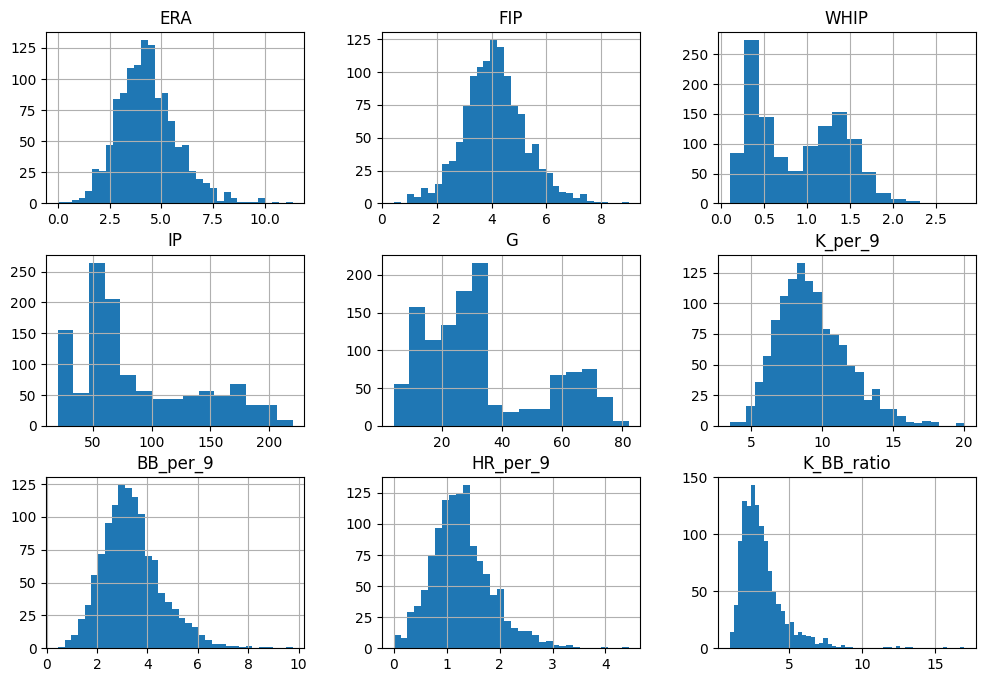

In [62]:
import matplotlib.pyplot as plt

# logging the counts of each attribute which contains non-numerical values
clean_data = pd.read_csv('/content/pitching_clean_2017_2020.csv')

print(clean_data["Team"].value_counts())
print(clean_data["Player"].value_counts())

# using the describe() method to get a summary of numerical attributes with percentiles
clean_data.describe()

# plotting a histogram for each numerical attribute in the cleaned data
cols = ["ERA","FIP","WHIP","IP","G","K_per_9","BB_per_9","HR_per_9","K_BB_ratio"]

clean_data[cols].hist(
    bins="fd",
    figsize=(12, 8),
    layout=(3, 3)
)

plt.show()

In [63]:

# implementing test/train split using unique identifiers for each player instance in the dataset
from sklearn.model_selection import train_test_split

# list of every unique pitcher name in the dataset, so if Clayton Kershaw appears in 2017, 2018, 2019, 2020...his name appears one and not 4 times
unique_players = clean_data["Player"].unique()

# split players list into two groups: train and test sets
# 80% of players go into train_players, 20% of players go into test_players
# random_state = 42 ensure that every time this split happens, the same split occurs preventing any leakage
train_players, test_players = train_test_split(
    unique_players,
    test_size=0.2,
    random_state=42
)

# Filter data based on player split
train_set = clean_data[clean_data['Player'].isin(train_players)].copy()
test_set = clean_data[clean_data['Player'].isin(test_players)].copy()

print(f"\nTrain set: {len(train_set)} pitcher-seasons, {len(train_players)} unique players")
print(f"Test set: {len(test_set)} pitcher-seasons, {len(test_players)} unique players")

# Save the sets
train_set.to_csv('/content/pitching_train.csv', index=False)
test_set.to_csv('/content/pitching_test.csv', index=False)
print("\nTrain and test sets saved!")


Train set: 947 pitcher-seasons, 491 unique players
Test set: 254 pitcher-seasons, 123 unique players

Train and test sets saved!
